# CUNY DATA620 Final Project

## Multi-Class Text Classification of Yelp Reviews


### Kyle Gilde

### 12/15/2018


Gleaning information from customer reviews presents both challenges and opportunities for businesses. The challenges include bringing a formal, objective & interpretable structure to unstructured, subjective natural language, while the results can yield valuable insights into customer attitudes towards the business.

For the final project, I will use a bag of words approach to build a machine learning classification model that uses text of Yelp customer reviews to predict the review's numerical `star` rating. In effect, we will see if we can build a sentiment analysis classifier. Our data set will be the [Yelp Open Dataset](https://www.yelp.com/dataset), which the company makes available for non-commercial use. 

We will experiment with different natural language processing techniques to normalize the text and with different machine learning algorithms. The modeling approach is inspired by Susan Li's Towards Data Science article called ["Multi-Class Text Classification with Scikit-Learn"](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f) and some of her code is used as starting point.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

From the original 6 million reviews, I used [this Python script](https://github.com/kylegilde/D620-Web-Analytics/blob/master/Final%20Project/resize-data.py) to retain only the reviews that were written starting in 2016 and that at least 10 other Yelp customers deemed "useful". The latter condition should reduce the amount of random noise caused by poorly written reviews.  With these conditions, our data set was over 33K reviews.

In [4]:
raw_data = pd.read_csv('D:/documents/yelp_reviews.csv')[['stars', 'text', 'useful']]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33255 entries, 0 to 33254
Data columns (total 3 columns):
stars     33255 non-null int64
text      33255 non-null object
useful    33255 non-null int64
dtypes: int64(2), object(1)
memory usage: 779.5+ KB


### The Response Variable

Our `star` response variable contains 5 imbalanced classes. The top rating of 5 is most common, closely followed by 4. The poorest rating of 1 is the third most common, followed by 3, and 2 stars is the least common class.

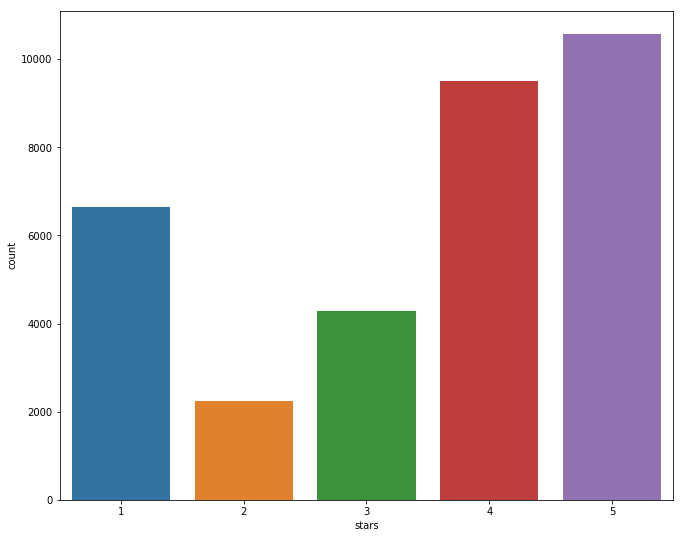

In [5]:
plt.figure(figsize=(11, 9))
sns.countplot(x='stars', data=raw_data)

### The Reviews

First, let's take a look at the most useful review from each star level. We observe the following:

- the reviews associated with bad ratings have more words that are completely capitalized and possibly more exclamation points. We may want to consider using these as features.
- the negative reviews seem to have more words of negation, e.g. "no" & "not". Normally, these common words would be removed from the text when we remove stopwords. However, for our purposes, we may want to consider leaving them in. Additionally, we may want to consider replacing negative contractions.
- we should see if the length of the review is positively correlated with the rating.


In [6]:
most_useful_review_idx = raw_data.groupby('stars')['useful'].idxmax()
most_useful_reviews = raw_data.loc[most_useful_review_idx, ['stars','text']].reset_index(drop=True)

pd.set_option('display.max_colwidth', 0)
display(HTML(most_useful_reviews.to_html(index=False)))
# Source: https://stackoverflow.com/a/35693013/4463701

stars,text
1,"Was in Scottsdale visiting a friend and we stopped by here for a bite to eat. Possibly one of the worst dining experiences I have ever had. The owner (at least I think he was the owner) came out from the back of the kitchen and almost assaulted another patron for complaining that his meal was frozen solid in the middle. The couple quickly left the restaurant and we had a chuckle at this odd behavior but waited for our pizza. \r\n\r\nWhen our pizza finally came it was AWFUL! Growing up in NY I am a bit of a pizza snob and let me tell you, this barely passed as edible. It was cold, the cheese wasn't fully cooked and looked like it might have actually been a microwavable pizza. When I asked if they could heat it in the oven for longer they copped the biggest attitude and made us wait for 30 minutes. Absolutely terrible! Eventually we just got up and let after leaving a tip for the waitress.\r\n\r\nI honestly thought I might have been on some type of reality TV show, that's how insanely BAD this place is!"
2,"With all the chemicals, pesticides, pollution, GMO's and hormone injected food, Whole Food stood up to provide organic food. However I think I just ate a gasoline brisket at this location. \r\n\r\nI like Whole Foods bread, salads and food bar. When I'm home in Chicago, I eat at WF every single day. Big fan. Recently I stopped by this location on my way to Pittsburgh airport. From outside, this location looks neat and brand new. It's spacious from the inside and has plenty of indoors and outside seats. \r\n\r\nI was all happy until I tasted the food. I added a piece of brisket, one piece of fried chicken and one chicken drumstick to my salad. Oh man!! When I opened the salad box, a strong petroleum smell slapped my nose. I found out it was coming from the brisket. I think they marinated the brisket in gasoline and charcoal. It was tender, but not edible. So I discarded it. The fried chicken was bone dry so I didn't eat it. The roasted chicken drumstick felt you're biting into big chunks of dry spices rub, ugh!. Left it alone as well. The green vegetables I added were really fresh and nice. But the gasoline taste overwhelmed everything. \r\n\r\nTo buy groceries, I think this WF is great and standard. For the food section, it would be nice if the manager or the cooks could taste the food before serving it. I was tired and in a hurry to complain about that gasoline charcoal brisket."
3,"Nutter Butter, Chips Ahoy! and Oreo cookie made into an awesome doughnut?! \r\n\r\nYes, please! \r\n\r\nHere's how the fabulous trio scored in taste and originality. \r\n\r\nThe Nutter Butter Cookie Twist Doughnut; covered in Krispy Kreme's signature glaze, dipped in peanut butter icing, topped with real Nutter Butter cookie pieces, then drizzled with more of the peanut butter icing. Phew! A lot of dipping and drizzling for a doughnut! \r\n\r\nAll worth the work for it actually tasted like the Nutter Butter cookies! Not too overpowering on the peanut butter taste, overall, this was my favorite of the three. \r\n\r\nThe Chips Ahoy! Doughnut; with cookie dough Kreme, topped with melted dark chocolate and a mini Chips Ahoy cookie. \r\n\r\nOne of the best dressed, but, it was super sweet, tasted like a regular Kreme doughnut and sort of a spin off of the Boston Cream pastry. It didn't have the cookie inspiration I was looking for. \r\n\r\nLastly, making its return, by popular demand, the Oreo Cookies and Kreme doughnut; Stuffed with an Oreo cookie flavored cream, then coated in dark chocolate icing, topped with Oreo cookie crumbles and finished off with a drizzle of icing.\r\n\r\nAgain a miss in the Oreo goodness. Very light in the cookies and cream flavor and the chocolate wasn't sharp enough. \r\n\r\nThere you have it. Do remember that all their doughnuts are ingredient Kosher, where certain factors are limited into getting that full, flavored taste that we are looking for. Still, an imaginative mash up. \r\n\r\n""So, whatever sprinkle

Contrary to what we suspected, the median number of words in 5-star level is the smallest, and the 2-star rating has the most.

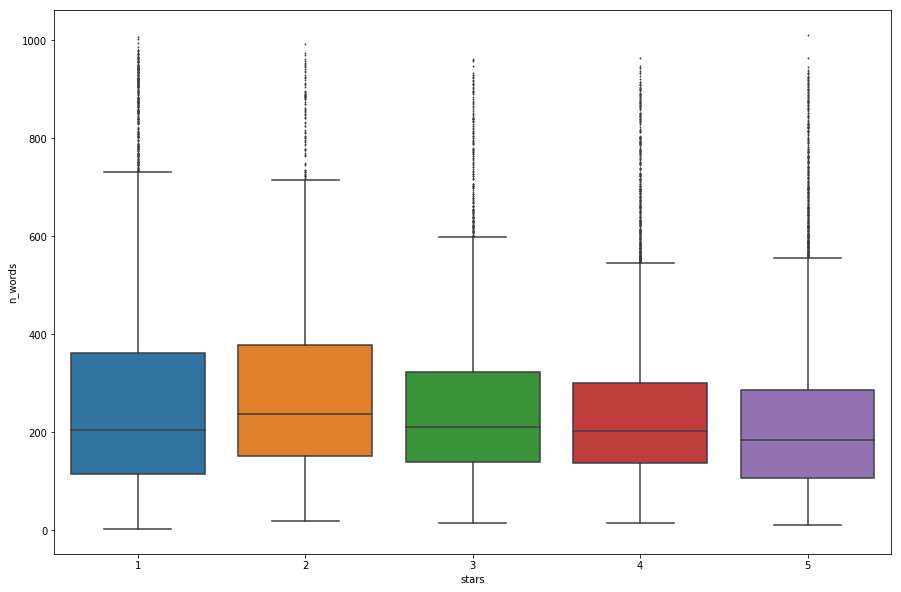

In [7]:
plt.figure(figsize=(15, 10))
# count words per review
raw_data['n_words'] = raw_data.text.str.lower().str.split().apply(len)
sns.boxplot(x='stars', y='n_words', fliersize=1, data=raw_data)

### Text Munging / Feature Engineering

Next, let's write some functions that will normalize our corpus. 

The normalization process includes the following:

- converting the text to lowercase
- let's test our hypothesis that the exclamation marks are indicative of the star rating. We will represent them with the token "exclampt" so that they don't get removed by our tokenizer.
- replacing "not" contractions with the word not
- removing the `nltk` stopwords, except for 'not', 'nor', 'no'
- keeping only the alphabetic tokens
- keeping only the tokens with a length greater than 1
- and finally, using Porter stemmer to replace all variantions with the word stem.

In [8]:
def replace_not_contractions(doc):
    """
    Passed as the callable to Pandas.apply()
    Replaces "n't" with " not"
    """
    if "n't" in doc:
        tokens = []
        for token in doc.split():
            if token.endswith("n't"):
                if token == "can't":
                    token = " can not "
                elif token == "won't":
                    token = " will not "
                else:
                    token = token.replace("n't", " not ")
            tokens.append(token)
        return ' '.join(tokens)  
    else:
        return doc


porter_stemmer = nltk.PorterStemmer()
revised_stopwords = [word for word in stopwords.words('english') if word not in ['not', 'nor', 'no']] 

def porter_stem_and_clean_text(doc):
    """
    Passed as the callable to Pandas.apply()
    Each token is stemmed and returned if it meets the conditions
    Sources: https://stackoverflow.com/a/36191362/4463701
    https://stackoverflow.com/a/51281480/4463701
    """
    stemmed_tokens = [porter_stemmer.stem(token) for token in nltk.word_tokenize(doc)\
                      if token.isalpha() # token contains only alphabetic characters
                      and len(token) > 1 # token is at least 2 characters long
                      and token not in revised_stopwords] # token is not among the revised stopwords
    return ' '.join(stemmed_tokens) 

raw_data['text_porter_stemmed'] = raw_data.text\
    .str.replace("!", " exclampt ")\
    .str.lower()\
    .apply(replace_not_contractions)\
    .apply(porter_stem_and_clean_text)

The result of this normalizing is that the number of unique words has from 120K to 43K, a reduction of 65%.

In [10]:
original_unique_terms = set(np.concatenate(raw_data.text.apply(nltk.word_tokenize)))
new_unique_terms = set(np.concatenate(raw_data.text_porter_stemmed.apply(nltk.word_tokenize)))

original_n_unique_terms, new_n_unique_terms = len(original_unique_terms), len(new_unique_terms)

print(original_n_unique_terms, new_n_unique_terms)
print(round((new_n_unique_terms / original_n_unique_terms - 1) * 100))

123000 43248
-65


Here is what a review looks like after these transformations.

In [12]:
raw_data.text_porter_stemmed[0][:1000]

'let prefac review state fact live year alway paid rent time respect neighbor commun respons tenant apart great year ago happen debat rent let fill realli year ago apart sold new owner downfal instead take care upgrad applianc upgrad landscap renter properli manag mainten request chose upgrad front offic futur tenant center increas curb appeal chose close main pool right summer pool close month offer no reimburs whatsoev sign leas entitl amen provid shown apart mailbox lock hardli ever work left open lot car patrol secur exist must gotten cut no seen past year eye apart build secur light left burn even mani mainten request clearli secur issu last decemb arm robberi mailbox exclampt two men jump nearbi bush area gun rob tenant no longer felt safe opinion poor manag care safeti tenant alreadi move care satisfact safeti sign leas know lock last year apart flood upstair unit time exclampt first faulti bathtub connect second time due mainten repair error state mainten man repair poorli took

### Unigram Document-Term Matrix and Term-Frequency-Inverse Document Frequency

Now we will create our features using the `create_n_gram_dtm` wrapper function for sci-kit learn's [`TfidfVectorizer` class](
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

This class creates a document-term matris. Each row represents a document, and the columns represent the document words. Instead of using token counts, we will use a calculation called term-frequency-inverse document frequency (TF-IDF). 

The TF-IDF values represent the importance of the term within each document and to the corpus as a whole. The numerator is the count of the term within the document, and the denominator is weighting which ues the [natural logrithm of the inverse document frequency](https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_extraction/text.py#L1242). The inverse document frequency is number of documents divided by the number of documents with that term. It is a measure of how unique this token is within the corpus.

Our default minimum document frequecy for a term will be set to 10. 



In [13]:
def create_n_gram_dtm(text_data, min_n_gram=1, max_n_gram=1, min_df=10):
    """
    Creates a document-term-matrix from a column of text
    :param text_data: a Pandas Series containing text
    :param max_n_gram: default is 1
    :param min_n_gram: default is 1
    :param min_df: default is 10
    :return: dtm sparse matrix and list of feature names
    """
    n_gram_vectorizer = TfidfVectorizer(min_df=min_df,
                                        ngram_range=(min_n_gram, max_n_gram))   
    dtm = n_gram_vectorizer.fit_transform(text_data)
    return (dtm, n_gram_vectorizer.get_feature_names())



unigram_dtm, unigram_feature_names = create_n_gram_dtm(raw_data.text_porter_stemmed)


After removing terms that occur less than 10 times, our total number decreases from 43K to 10626.

In [14]:
print(len(unigram_feature_names))

10626


### Top Class-Correlated Tokens

The next function calculates the chi-squared statistic for each of terms and classes and plots the top 10 terms by class.


In [15]:
RESPONSE_LABEL_VALUES = np.sort(raw_data.stars.unique())

def plot_most_correlated_tokens(dtm, feature_names, n_grams = 1, labels = raw_data.stars, top_n_tokens = 10):
    """
    Calculates the chi-squared statistic for each of terms and classes 
    and plots the top 10 terms by class.
    
    :param dtm: a sparse matrix
    :param feature_names: list of feature names
    :param n_grams: select the n-gram
    :param labels: list of response labels for each document
    :param top_n_tokens: select the top n
    :return: None
    Sources: https://github.com/mwaskom/seaborn/issues/867#issuecomment-184918644
    """
    # initialize empty df
    top_chi2_df = pd.DataFrame(columns=['stars', 'feature_name', 'chi2_value'])
    for response_label_value in RESPONSE_LABEL_VALUES:   
        features_chi2 = chi2(dtm, labels==response_label_value) # calc chi^2 for the class
        indices = np.argsort(features_chi2[0]) # get the sorted indices
        feature_names_sorted = np.array(feature_names)[indices] # sort feature names ascendinglyly    
        top_feature_names = feature_names_sorted[-top_n_tokens:]
        top_chi2_values = np.sort(features_chi2[0])[-top_n_tokens:]
        stars_df = pd.DataFrame({'stars': np.repeat(response_label_value, top_n_tokens), 
                                 'feature_name': top_feature_names,
                                 'chi2_value': top_chi2_values})   
        top_chi2_df = pd.concat([top_chi2_df, stars_df], sort=True)

    # create Faceted Grid Plot
    g = sns.FacetGrid(col="stars", col_wrap=3, sharex=False, margin_titles=True, data=top_chi2_df)
    g.map(sns.barplot, "feature_name", "chi2_value", color="steelblue")
    [plt.setp(ax.get_xticklabels(), rotation=45, fontsize=15) for ax in g.axes.flat]
    sns.set(font_scale=2)
    plt.subplots_adjust(hspace=.75, wspace=.3) # https://stackoverflow.com/a/43699744/4463701
    g.fig.set_size_inches(20,15) # https://stackoverflow.com/a/46346780/4463701

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
# https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_selection/univariate_selection.py#L172


We observe the following:

- Our "exclampt" feature has a top chi-squared value for star ratings 2, 3 & 5. 

- Unexpectedly, the term "not" is very relevant to the 5 stars class. The other negative stopwords "no" and "nor" did not make the top ten list.

- In the 1-star class, the top words appropriately include "money", "refund" and "manager."  We also notice that test statitics are much higher than all of the other classes. Let's see if the 1-star rating ends up being the easiest class to predict.

- In the 3-star class, the top words appropriately include "ok," "decent" and "average"

- In the 5-star class, the top words appropriately include "great," "best", "awesome" and "amazing."

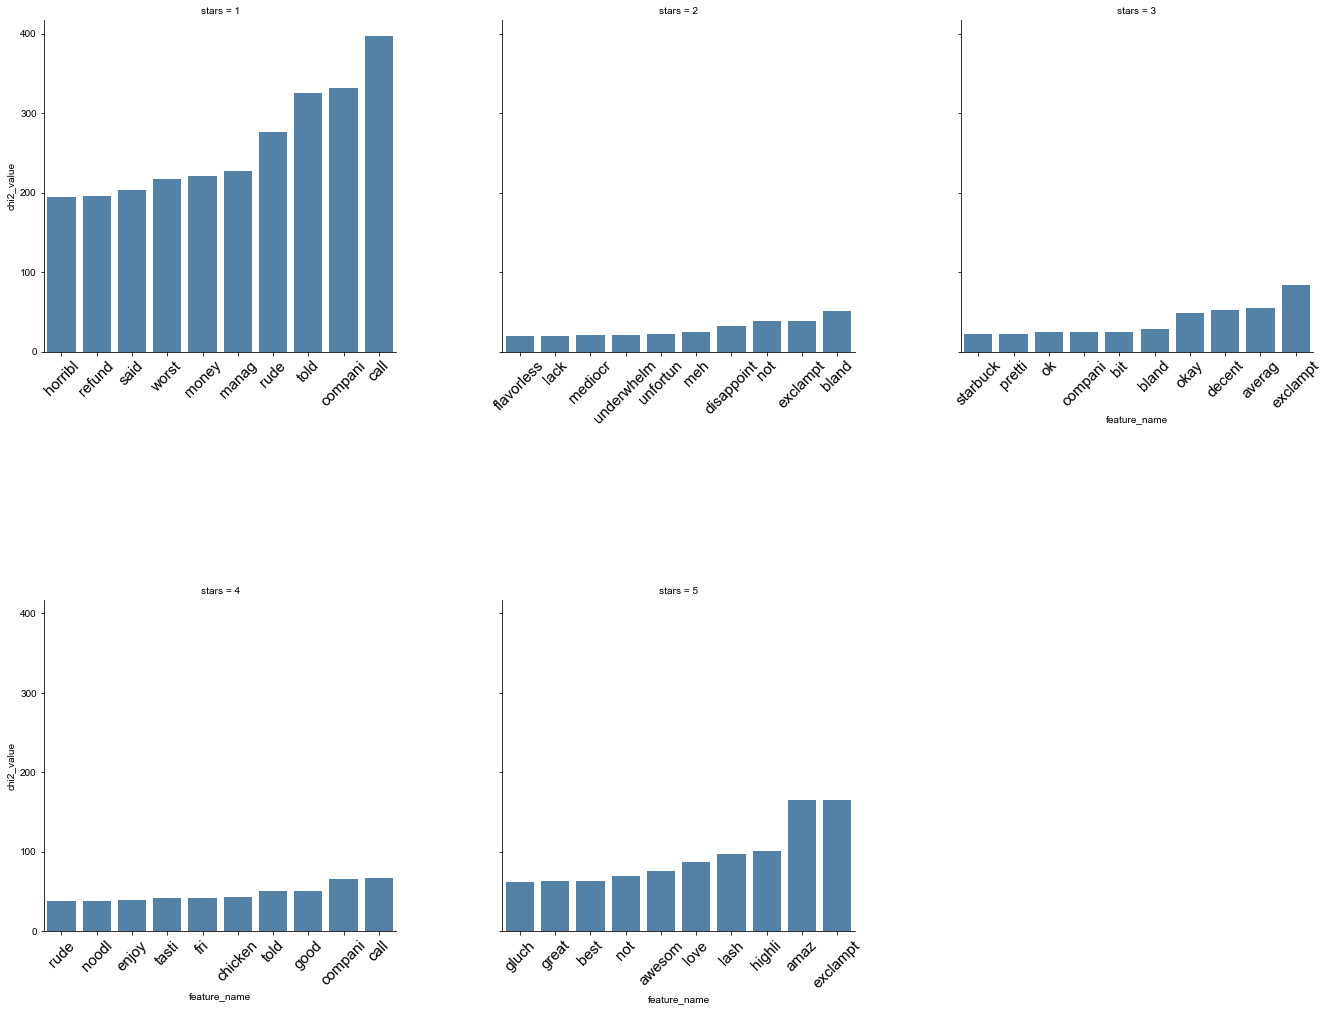

In [16]:
plot_most_correlated_tokens(unigram_dtm, unigram_feature_names)

### Unigram Modeling

We are going to try our unigram features with three models, including linear support vector machines (SVM), multinomial naive Bayes (NB) and multinomial logistic regression (logreg), also known as maximum entropy. We are using the multinomial forms of the latter two since we are predicting more than two classes.

We are going to reserve 25% of the reviews for a test data set and will perform a 5-fold cross validation on our training data set.


In [17]:
X_train_indices, X_test_indices, y_train, y_test = train_test_split(raw_data.index,\
                                                                    raw_data.stars,\
                                                                    test_size=.25,\
                                                                    random_state = 0)

models = [
    LinearSVC(random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5

def perform_cross_val(models, X_train, y_train, cv=CV):
    """
    perform cross-validation model fitting
    and returns the results
    
    :param models: list of sci-kit learn model classes
    :param X_train: training data set
    :param y_train: response labels
    :param cv: # of folds
    :return: a df with the accuracies for each model and fold
    """
    entries = []
    for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
      
    return pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

unigram_cv_results = perform_cross_val(models, unigram_dtm[X_train_indices, ], y_train)

The `plot_cv_results` function shows the distributions of the accuracy metrics for each fold in each of our models.


In [18]:
def plot_cv_results(cv_df):
    """
    Plots the distributions of the accuracy metrics 
    for each fold in each of our models.
    
    :param cv_df: the output df from perform_cross_val
    :return: None
    """
    plt.figure(figsize=[10, 10])
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    f = sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    f.xaxis.tick_top() # x labels on top
    plt.setp(f.get_xticklabels(), rotation=30, fontsize=20) # rotate and increase x labels

    plt.show()
    display(cv_df[['model_name', 'accuracy']]\
                 .groupby('model_name')\
                 .mean().sort_values(by='accuracy', ascending=False))


Of our 3 unigram models, the logreg model performed the best with a mean 5-fold accuracy of 64.48%, followed closely by SVC and then NB.

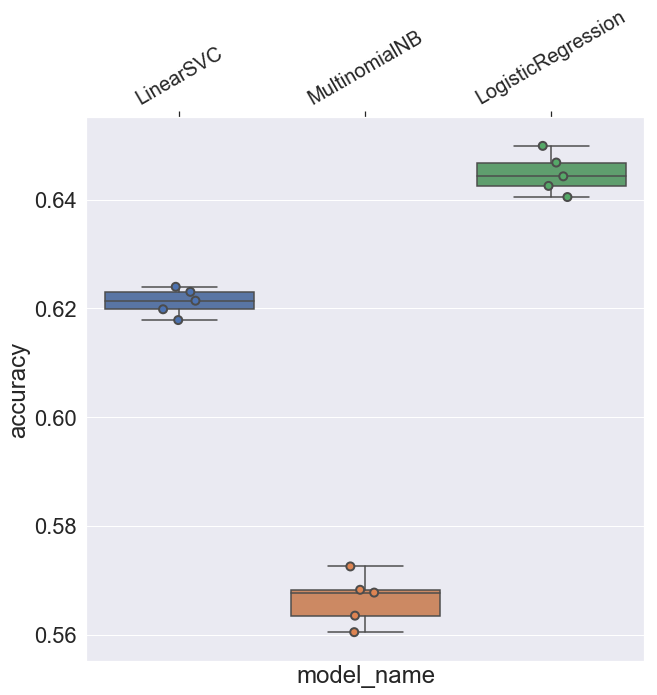

,accuracy
model_name,
LogisticRegression,0.644802
LinearSVC,0.621226
MultinomialNB,0.566496


In [19]:
plot_cv_results(unigram_cv_results)

### Bigram Modeling

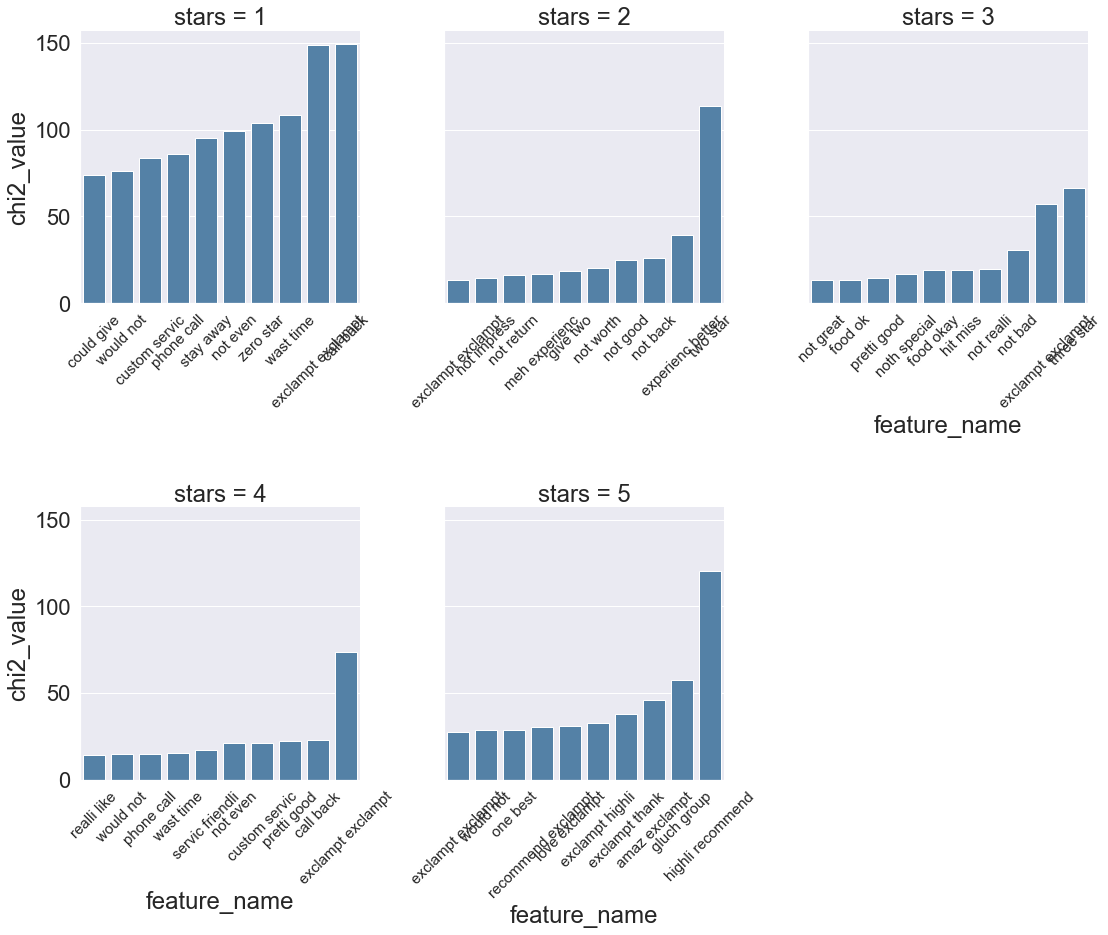

In [20]:
bigram_dtm, bigram_feature_names = create_n_gram_dtm(raw_data.text_porter_stemmed, 2, 2)

plot_most_correlated_tokens(bigram_dtm, bigram_feature_names)

### Bigram Cross-Validation

In [21]:
bigram_cv_results = perform_cross_val(models, bigram_dtm[X_train_indices, ], y_train)
plot_cv_results(bigram_cv_results)

### Trigram Modeling

In [ ]:
trigram_dtm, trigram_feature_names = create_n_gram_dtm(raw_data.text_porter_stemmed, 3, 3)

plot_most_correlated_tokens(trigram_dtm, trigram_feature_names)

AttributeError: 'DataFrame' object has no attribute 'text_porter_stemmed'

### Trigram Cross-Validation



In [ ]:
trigram_cv_results = perform_cross_val(models, trigram_dtm[X_train_indices, ], y_train)


plot_cv_results(trigram_cv_results)

NameError: name 'trigram_dtm' is not defined

In [75]:

# analyzer = CountVectorizer().build_analyzer() 

# def stem_text(doc):
#     """
#     Passed as the callable for sklearn.feature_extraction.text classes
#     Each token is stemmed and returned if it meets the conditions
#     Source: https://stackoverflow.com/a/36191362/4463701
#     """
#     return (stemmer.stem(token) for token in analyzer(doc)\
#             if token.isalpha() and len(token) > 1 and token not in revised_stopwords)

# def text_processor_nltk(word):
#     """"""
#         return stemmer.stem(word).lower() if word.isalpha() and len(word) > 1 and word not in revised_stopwords
    
#text_cleaned = list(map(text_cleaner_v1, nl_text))
# text_cleaned = list(map(, nl_text))

# plt.figure(figsize=(15, 15))
# sns.boxplot(x='useful', y='stars', orient='h', fliersize=1, data=raw_data)

# plt.figure(figsize=(15, 15))
# sns.boxplot(x='useful', y='stars', orient='h', fliersize=1, data=raw_data)

# sns.set(style="darkgrid")

# plt.figure(figsize=(9, 15))
# g = sns.FacetGrid(raw_data, col="stars", margin_titles=True)
# bins = np.linspace(0, np.max(raw_data['useful']), )
# g.map(plt.hist, "useful", color="steelblue", bins=bins)

# sns.distplot(raw_data['useful'])
# sns.heatmap(raw_data[['stars', 'useful']].pivot_table(index='useful', columns='stars'))

# sns.heatmap(raw_data.groupby(['stars', 'useful']).size().unstack(fill_value=0))
# https://stackoverflow.com/a/40839983/4463701